In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from plot_functions import *
from sklearn.model_selection import KFold

In [2]:
from create_matrix import *

from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "SanDiego"
year = 2014

import os


def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [3]:
n_splits = 10
import sys
case=2
a=2
cost='abs'

In [4]:
def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [5]:
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)

In [6]:
df, dfc = create_matrix_single_region("SanDiego", year)
tensor = get_tensor(df, dfc)

In [7]:
from sklearn.model_selection import train_test_split, KFold

In [8]:
n_splits = 10


In [9]:
from common import compute_rmse

In [10]:
np.arange(0.1, 1.0, 0.1)

array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])

In [11]:
pred = {}
sd = {}
out = {}
n_splits = 10
NUM_RANDOM = 1
TRAIN_SPLITS = range(10, 110, 40)
case = 2

cost = 'rel'
for algo in ['adagrad']:
    np.random.seed(0)
    pred[algo] = {}
    for a in range(2, 3):
       
        pred[algo][a] = {}
        for random_seed in range(NUM_RANDOM):
            pred[algo][a][random_seed] = {}
            for appliance in APPLIANCES_ORDER:
                pred[algo][a][random_seed][appliance] = {f:[] for f in TRAIN_SPLITS}

        kf = KFold(n_splits=n_splits)
        for random_seed in range(NUM_RANDOM):

            for train_percentage in TRAIN_SPLITS:
                print(algo, a, random_seed,train_percentage)
                for train_max, test in kf.split(df):

                    num_train = int((train_percentage*len(train_max)/100)+0.5)
                    if train_percentage==100:
                        train = train_max
                    else:
                        train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)
                    train_ix = df.index[train]
                    test_ix = df.index[test]

                    num_test = len(test_ix)
                    train_test_ix = np.concatenate([test_ix, train_ix])
                    df_t, dfc_t = df.ix[train_test_ix], dfc.ix[train_test_ix]
                    tensor = get_tensor(df_t, dfc_t)
                    tensor_copy = tensor.copy()
                    # First n
                    tensor_copy[:num_test, 1:, :] = np.NaN
                    if algo=="adagrad":
                        H, A, T = learn_HAT_adagrad(case, tensor_copy, a, a, num_iter=1200, lr=1, dis=False, cost_function=cost)
                    elif algo=='gd':
                        H, A, T = learn_HAT(case, tensor_copy, a, a, num_iter=4000, lr=0.1, dis=False, cost_function=cost)
                    else:
                        H, A, T = learn_HAT(case, tensor_copy, a, a, num_iter=4000, lr=1, dis=False, cost_function=cost, decay_mul=0.995)

                    HAT = multiply_case(H, A, T, case)
                    for appliance in APPLIANCES_ORDER:
                        pred[algo][a][random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))


('adagrad', 2, 0, 10)


/Users/nipunbatra/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


('adagrad', 2, 0, 50)
('adagrad', 2, 0, 90)


In [11]:
from common import compute_rmse_fraction

In [13]:
out = {}
for algo in ['adagrad']:
    out[algo] = {}
    for a in range(2, 3):
        out[algo][a] = {}
        for random_seed in range(NUM_RANDOM):
            out[algo][a][random_seed] = {}

            for appliance in APPLIANCES_ORDER[1:]:
                out[algo][a][random_seed][appliance] = {}
                for f in TRAIN_SPLITS:
                    s = pd.concat(pred[algo][a][random_seed][appliance][f]).ix[df.index]
                    if appliance=="hvac":
                            out[algo][a][random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
                    else:   
                        out[algo][a][random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

    

/Users/nipunbatra/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  if sys.path[0] == '':


In [14]:
ada_df= pd.Panel(out['adagrad'][a]).mean(axis=0)


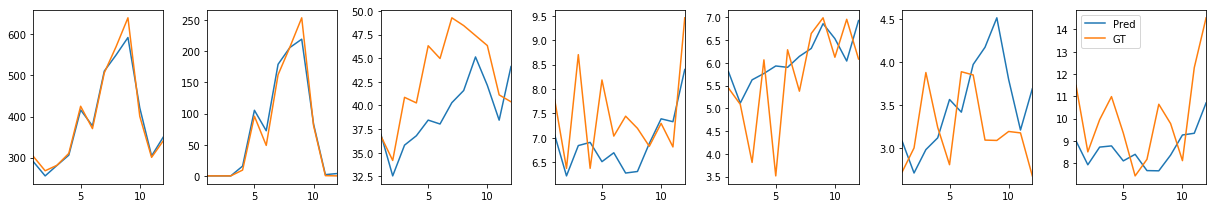

In [12]:
H, A, T = learn_HAT_adagrad(case, tensor, a, a, num_iter=1200, lr=1, dis=False, cost_function='abs')
HAT = multiply_case(H, A, T, 2)
fig, ax  = plt.subplots(ncols=7, figsize=(17, 3))
for i, appliance in enumerate(APPLIANCES_ORDER):
    pred = pd.DataFrame(HAT[:, i, :]).mean()
    pred.index = range(1, 13)
    pred.plot(ax=ax[i], label='Pred')
    gt = df[['{}_{}'.format(appliance, month) for month in range(1, 13)]].mean()
    gt.index = range(1, 13)
    gt.plot(ax=ax[i],label='GT')
plt.legend()
fig.tight_layout()    

(0.82803161705934292, 20.0, 0)
(0.61419402061505946, 15.575041866269189, 500)
(0.58552041484733275, 12.1290964568019, 1000)
(0.55706058978901862, 9.4455592557353434, 1500)
(0.53585793104483215, 7.3557490429202197, 2000)
(0.51757141982665522, 5.7283049650625966, 2500)
(0.50227362793465835, 4.4609294826803803, 3000)
(0.48987400039247048, 3.4739581727610735, 3500)
(0.47915630682073845, 2.7053521991210867, 4000)
(0.4697830143619155, 2.1067986882157168, 4500)
(0.46235892260248179, 1.6406738886380399, 5000)
(0.4567466450249173, 1.277678225221607, 5500)
(0.45277798302611266, 0.99499459247235222, 6000)
(0.45167329970007886, 0.77485412172341672, 6500)
(0.4513789440209568, 0.60341926930467282, 7000)
(0.45122394364090396, 0.46991401911669206, 7500)


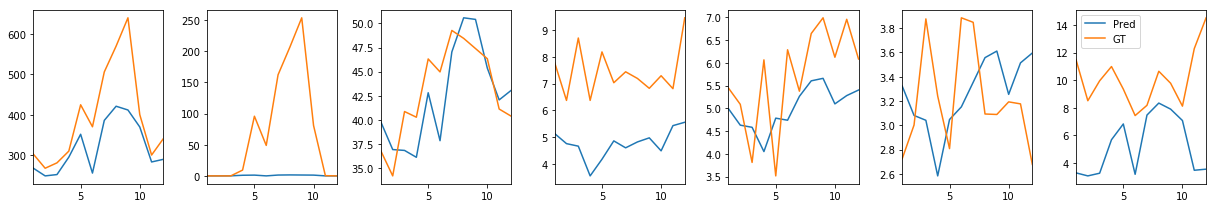

In [46]:
H, A, T = learn_HAT(case, tensor, a, a, num_iter=8000, lr=20, dis=True, cost_function='rel', decay_mul=0.9995)
HAT = multiply_case(H, A, T, 2)
fig, ax  = plt.subplots(ncols=7, figsize=(17, 3))
for i, appliance in enumerate(APPLIANCES_ORDER):
    pred = pd.DataFrame(HAT[:, i, :]).mean()
    pred.index = range(1, 13)
    pred.plot(ax=ax[i], label='Pred')
    gt = df[['{}_{}'.format(appliance, month) for month in range(1, 13)]].mean()
    gt.index = range(1, 13)
    gt.plot(ax=ax[i],label='GT')
plt.legend()
fig.tight_layout() 

(0.8403065100695799, 0.10000000000000001, 0)
(0.81622580540842915, 0.10000000000000001, 500)
(0.79546200004375578, 0.10000000000000001, 1000)
(0.77686774294045302, 0.10000000000000001, 1500)
(0.76354843177732357, 0.10000000000000001, 2000)
(0.75353305334554765, 0.10000000000000001, 2500)
(0.74481888076587766, 0.10000000000000001, 3000)
(0.7365154918730068, 0.10000000000000001, 3500)
(0.72833814637561189, 0.10000000000000001, 4000)
(0.7203276649201209, 0.10000000000000001, 4500)
(0.71215416527565234, 0.10000000000000001, 5000)
(0.70402489976443905, 0.10000000000000001, 5500)
(0.69585478296219128, 0.10000000000000001, 6000)
(0.68756784038272523, 0.10000000000000001, 6500)
(0.6791491101474626, 0.10000000000000001, 7000)
(0.67067779975805852, 0.10000000000000001, 7500)
(0.66232421957255405, 0.10000000000000001, 8000)
(0.65433074771682764, 0.10000000000000001, 8500)
(0.64693115915598554, 0.10000000000000001, 9000)
(0.64032226342630982, 0.10000000000000001, 9500)
(0.63455463186233874, 0.1000

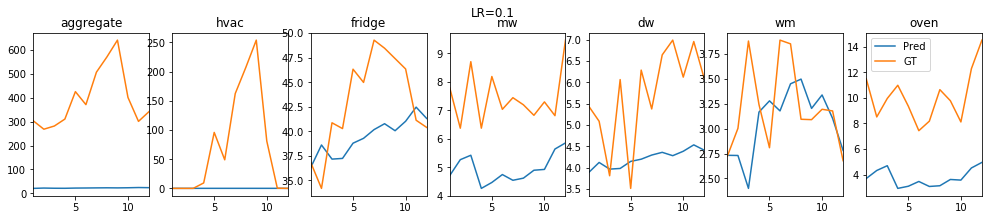

In [71]:
H, A, T = learn_HAT(case, tensor, a, a, num_iter=20000, lr=0.1, dis=True, cost_function='rel', decay_mul=1, aggregate_constraint=False)
HAT = multiply_case(H, A, T, 2)
fig, ax  = plt.subplots(ncols=7, figsize=(17, 3))
for i, appliance in enumerate(APPLIANCES_ORDER):
    pred = pd.DataFrame(HAT[:, i, :]).mean()
    pred.index = range(1, 13)
    pred.plot(ax=ax[i], label='Pred')
    gt = df[['{}_{}'.format(appliance, month) for month in range(1, 13)]].mean()
    gt.index = range(1, 13)
    gt.plot(ax=ax[i],label='GT')
    ax[i].set_title(appliance)
plt.suptitle("LR=0.1", y=1)
plt.legend()
#fig.tight_layout() 

(0.81058016466020866, 100.0, 0)
(0.68076777360647345, 81.869799576745322, 500)
(0.61826461047523007, 67.026640827364503, 1000)
(0.64888014198372335, 54.874576508388273, 1500)
(0.67599954605871204, 44.925705806005254, 2000)
(0.71173202517216139, 36.780585301814746, 2500)
(0.51078094267932006, 30.112191469749582, 3000)
(0.5137106269891526, 24.652790804449786, 3500)
(0.52480412799264309, 20.183190421677345, 4000)
(0.50330691021560481, 16.523937546420104, 4500)
(0.46546660913756321, 13.528114551440707, 5000)
(0.46090055673685371, 11.075440269777028, 5500)
(0.45719740772826484, 9.0674407511085953, 6000)
(0.45418136169114465, 7.4234955696727392, 6500)
(0.44573655205301099, 6.0776009444796397, 7000)
(0.43909185502008186, 4.9757197123198624, 7500)
(0.43072625792925345, 4.0736117559768807, 8000)
(0.42583147163637031, 3.3350577801530084, 8500)
(0.42304318770390753, 2.73040512037992, 9000)
(0.42074347960055769, 2.2353771996882323, 9500)
(0.41869866357176261, 1.8300988331690182, 10000)
(0.41697645

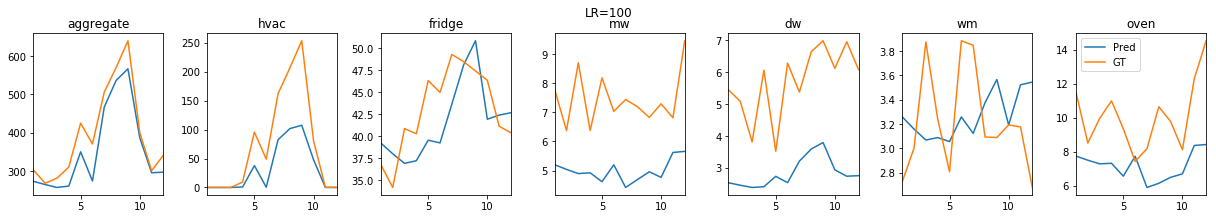

In [72]:
H, A, T = learn_HAT(case, tensor, a, a, num_iter=20000, lr=100, dis=True, cost_function='rel', decay_mul=0.9996, aggregate_constraint=False)
HAT = multiply_case(H, A, T, 2)
fig, ax  = plt.subplots(ncols=7, figsize=(17, 3))
for i, appliance in enumerate(APPLIANCES_ORDER):
    pred = pd.DataFrame(HAT[:, i, :]).mean()
    pred.index = range(1, 13)
    pred.plot(ax=ax[i], label='Pred')
    gt = df[['{}_{}'.format(appliance, month) for month in range(1, 13)]].mean()
    gt.index = range(1, 13)
    gt.plot(ax=ax[i],label='GT')
    ax[i].set_title(appliance)
plt.suptitle("LR=100", y=1)
plt.legend()
fig.tight_layout() 

(0.82596977207962829, 20.0, 0)
(0.5794209911895426, 15.575041866269189, 500)
(0.54593279429892982, 12.1290964568019, 1000)
(0.50971162913474211, 9.4455592557353434, 1500)
(0.48972057251832585, 7.3557490429202197, 2000)
(0.47600610926887571, 5.7283049650625966, 2500)
(0.46770118657414234, 4.4609294826803803, 3000)
(0.46211403872360685, 3.4739581727610735, 3500)
(0.4580490524746913, 2.7053521991210867, 4000)
(0.45513360572543782, 2.1067986882157168, 4500)
(0.45328334429792677, 1.6406738886380399, 5000)
(0.45174959598921588, 1.277678225221607, 5500)
(0.45109732374228767, 0.99499459247235222, 6000)
(0.45088138492706753, 0.77485412172341672, 6500)
(0.45076622375195746, 0.60341926930467282, 7000)
(0.45069342067076185, 0.46991401911669206, 7500)


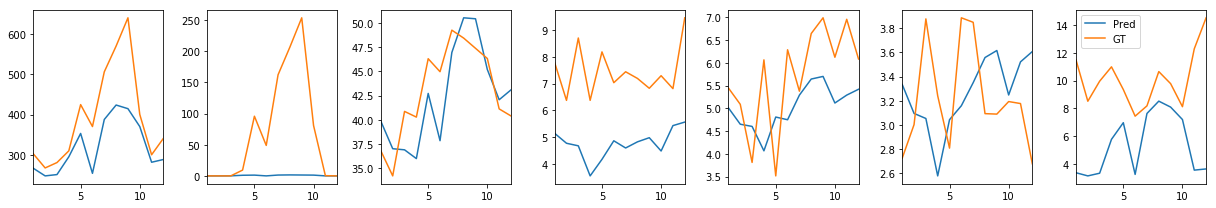

In [45]:
H, A, T = learn_HAT(case, tensor, a, a, num_iter=8000, lr=20, dis=True, cost_function='rel', decay_mul=0.9995, aggregate_constraint=True)
HAT = multiply_case(H, A, T, 2)
fig, ax  = plt.subplots(ncols=7, figsize=(17, 3))
for i, appliance in enumerate(APPLIANCES_ORDER):
    pred = pd.DataFrame(HAT[:, i, :]).mean()
    pred.index = range(1, 13)
    pred.plot(ax=ax[i], label='Pred')
    gt = df[['{}_{}'.format(appliance, month) for month in range(1, 13)]].mean()
    gt.index = range(1, 13)
    gt.plot(ax=ax[i],label='GT')
plt.legend()
fig.tight_layout() 

In [43]:
gd_df

,dw,fridge,hvac,mw,oven,wm
10,2.299307,9.886383,20.753686,2.098311,2.722512,3.212808
50,2.018853,7.476048,20.049335,1.858464,2.237111,0.836817
90,1.902759,7.066616,16.886701,1.746953,2.140509,0.746793


In [44]:
gd_decay_df

,dw,fridge,hvac,mw,oven,wm
10,2.242566,9.824156,18.803663,2.088030,3.113946,2.883576
50,1.996045,7.323826,16.822711,1.834284,2.174558,0.747044
90,1.902341,7.047535,16.487236,1.748179,2.127111,0.717527


In [34]:
gd_decay_df

,dw,fridge,hvac,mw,oven,wm
10,7.861015,39.770204,105.041879,7.627698,11.664919,11.209887
50,6.506094,23.692135,98.334377,6.070128,7.387452,2.595948
90,6.209113,19.733306,90.395893,5.448192,7.027339,2.338634


In [45]:
import pickle
pickle.dump(ada_gd, open("predictions/normal_ada_gd.pkl", 'w'))

In [23]:
means = {}
stds = {}
for a in range(2, 5):
    means[a] = pd.Panel(out[a]).mean(axis=0)
    stds[a] = pd.Panel(out[a]).std(axis=0)

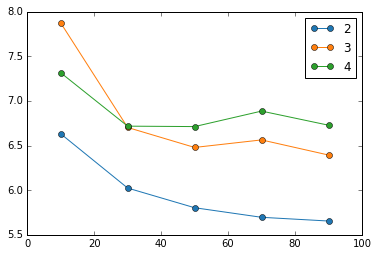

In [38]:
mean_mean = pd.DataFrame({a:means[a].mean(axis=1) for a in range(2, 5)})
mean_mean.plot(color=tableau20blind[::2], marker='o', xlim=(0, 100))

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/pandas/tools/plotting.py:983: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


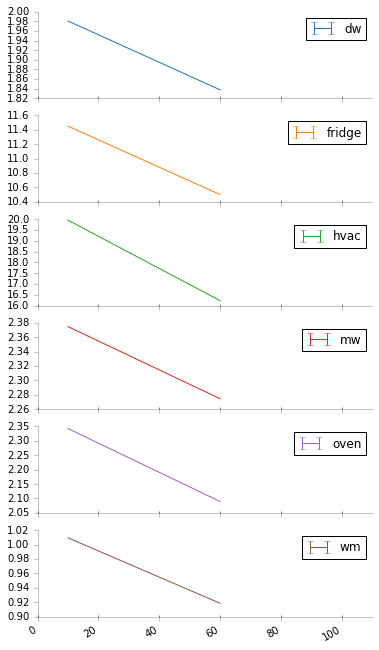

In [20]:
ax = means_df.plot(subplots=True, yerr=std_df, figsize=(6, 12), xlim=(0, 110), colors=tableau20blind[::2])
for a in ax:
    format_axes(a)

In [39]:
st = pd.HDFStore('transfer.h5', mode='a')
st['/transfer_mean'] = mean_mean
#st['/transfer_sd'] = std_df
print st.keys()
st.close()

['/normal_mean', '/normal_sd', '/transfer_mean', '/transfer_sd']


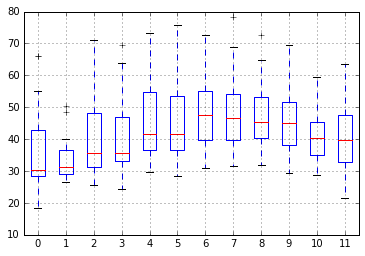

In [85]:
#prediction_appliance.boxplot()
gt_appliance = df[['%s_%d' %(appliance, month) for month in range(1, 13)]]
gt_appliance.columns = prediction_appliance.columns
gt_appliance.boxplot()

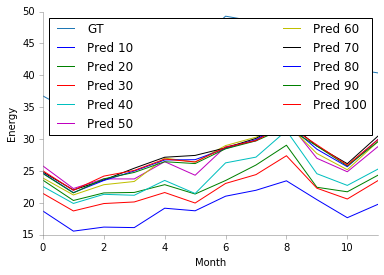

In [113]:
gt_appliance.mean().plot(label='GT', color=tableau20blind[::2][0])
for f in range(10, 110, 10):
  
    random_seed=2
    appliance='fridge'
    prediction_appliance = pd.concat(pred[random_seed][appliance][f]).ix[df.index]
    prediction_appliance.mean().plot(label='Pred '+str(f))
plt.legend(loc=0, mode="expand", ncol=2)
format_axes(plt.gca())
plt.xlabel("Month")
plt.ylabel("Energy")

In [114]:
import pickle
pickle.dump(pred, open("predictions/transfer_pred.pkl", 'w'))

In [117]:
!ls -lah predictions/transfer_pred.pkl

-rw-r--r--  1 nipunbatra  staff    10M Jun 26 16:59 predictions/transfer_pred.pkl


In [ ]:
E_np